# Hierarchical Modeling

[Example source](https://nbviewer.org/github/AllenDowney/BayesianInferencePyMC/blob/main/soln/04_hierarchical.ipynb)


In [4]:
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt
from cycler import cycler
import arviz as az
import pandas as pd

In [5]:
# Plot theming
sns.set_theme(style="darkgrid", rc={"grid.linestyle": ":"})
colors10 = [
    "#001219",
    "#005F73",
    "#0A9396",
    "#94D2BD",
    "#E9D8A6",
    "#EE9B00",
    "#CA6702",
    "#BB3E03",
    "#AE2012",
    "#9B2226",
]
linestyle_cycler = cycler(
    "color",
    colors10 * 2,
) + cycler("linestyle", ["-"] * 10 + ["--"] * 10)

In [7]:
df = pd.read_csv("example_data/manhattan_heart_attacks.csv")

In [8]:
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


Gamma Distribution
------------------

$$f(x | \alpha,\beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$

where:
- $x > 0$
- $\alpha > 0$ is the shape parameter,
- $\beta > 0$ is the rate parameter,
- $\Gamma(\alpha)$ is the gamma function. It's defined as $\Gamma(\alpha) = \int_{0}^{\infty} t^{\alpha-1}e^{-t} dt$.


Binomial Distribution
---------------------

$$
P(X=k) = \binom{n}{k} p^k (1-p)^{n-k}
$$

where:
- $n$ is the number of trials,
- $p$ is the probability of success on each trial,
- $k$ is the number of successes.


Beta Distribution
-----------------

$$
f(x|\alpha,\beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)}
$$

where:
- $\alpha$ and $\beta$ are shape parameters,
- $B(\alpha,\beta)$ is the Beta function given by $B(\alpha, \beta) = \int_0^1 t^{\alpha - 1} (1 - t)^{\beta - 1} dt$



In [9]:
with pm.Model() as model:
    alpha = pm.Gamma("alpha", alpha=4, beta=0.5)
    beta = pm.Gamma("beta", alpha=4, beta=0.5)
    xs = pm.Beta("xs", alpha, beta, shape=len(df.index))
    ks = pm.Binomial(
        "ks",
        n=df["Cases"].to_numpy(),
        p=xs,
        observed=df["Deaths"].to_numpy(),
    )

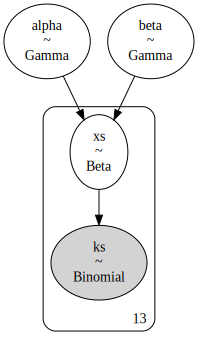

In [11]:
pm.model_to_graphviz(model)

In [12]:
with model:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, xs]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [17]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

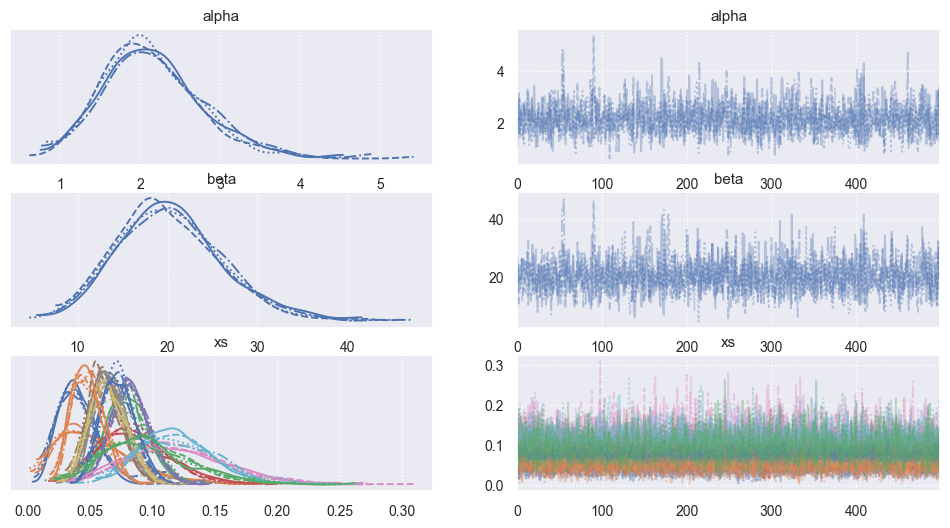

In [13]:
with model:
    az.plot_trace(trace)

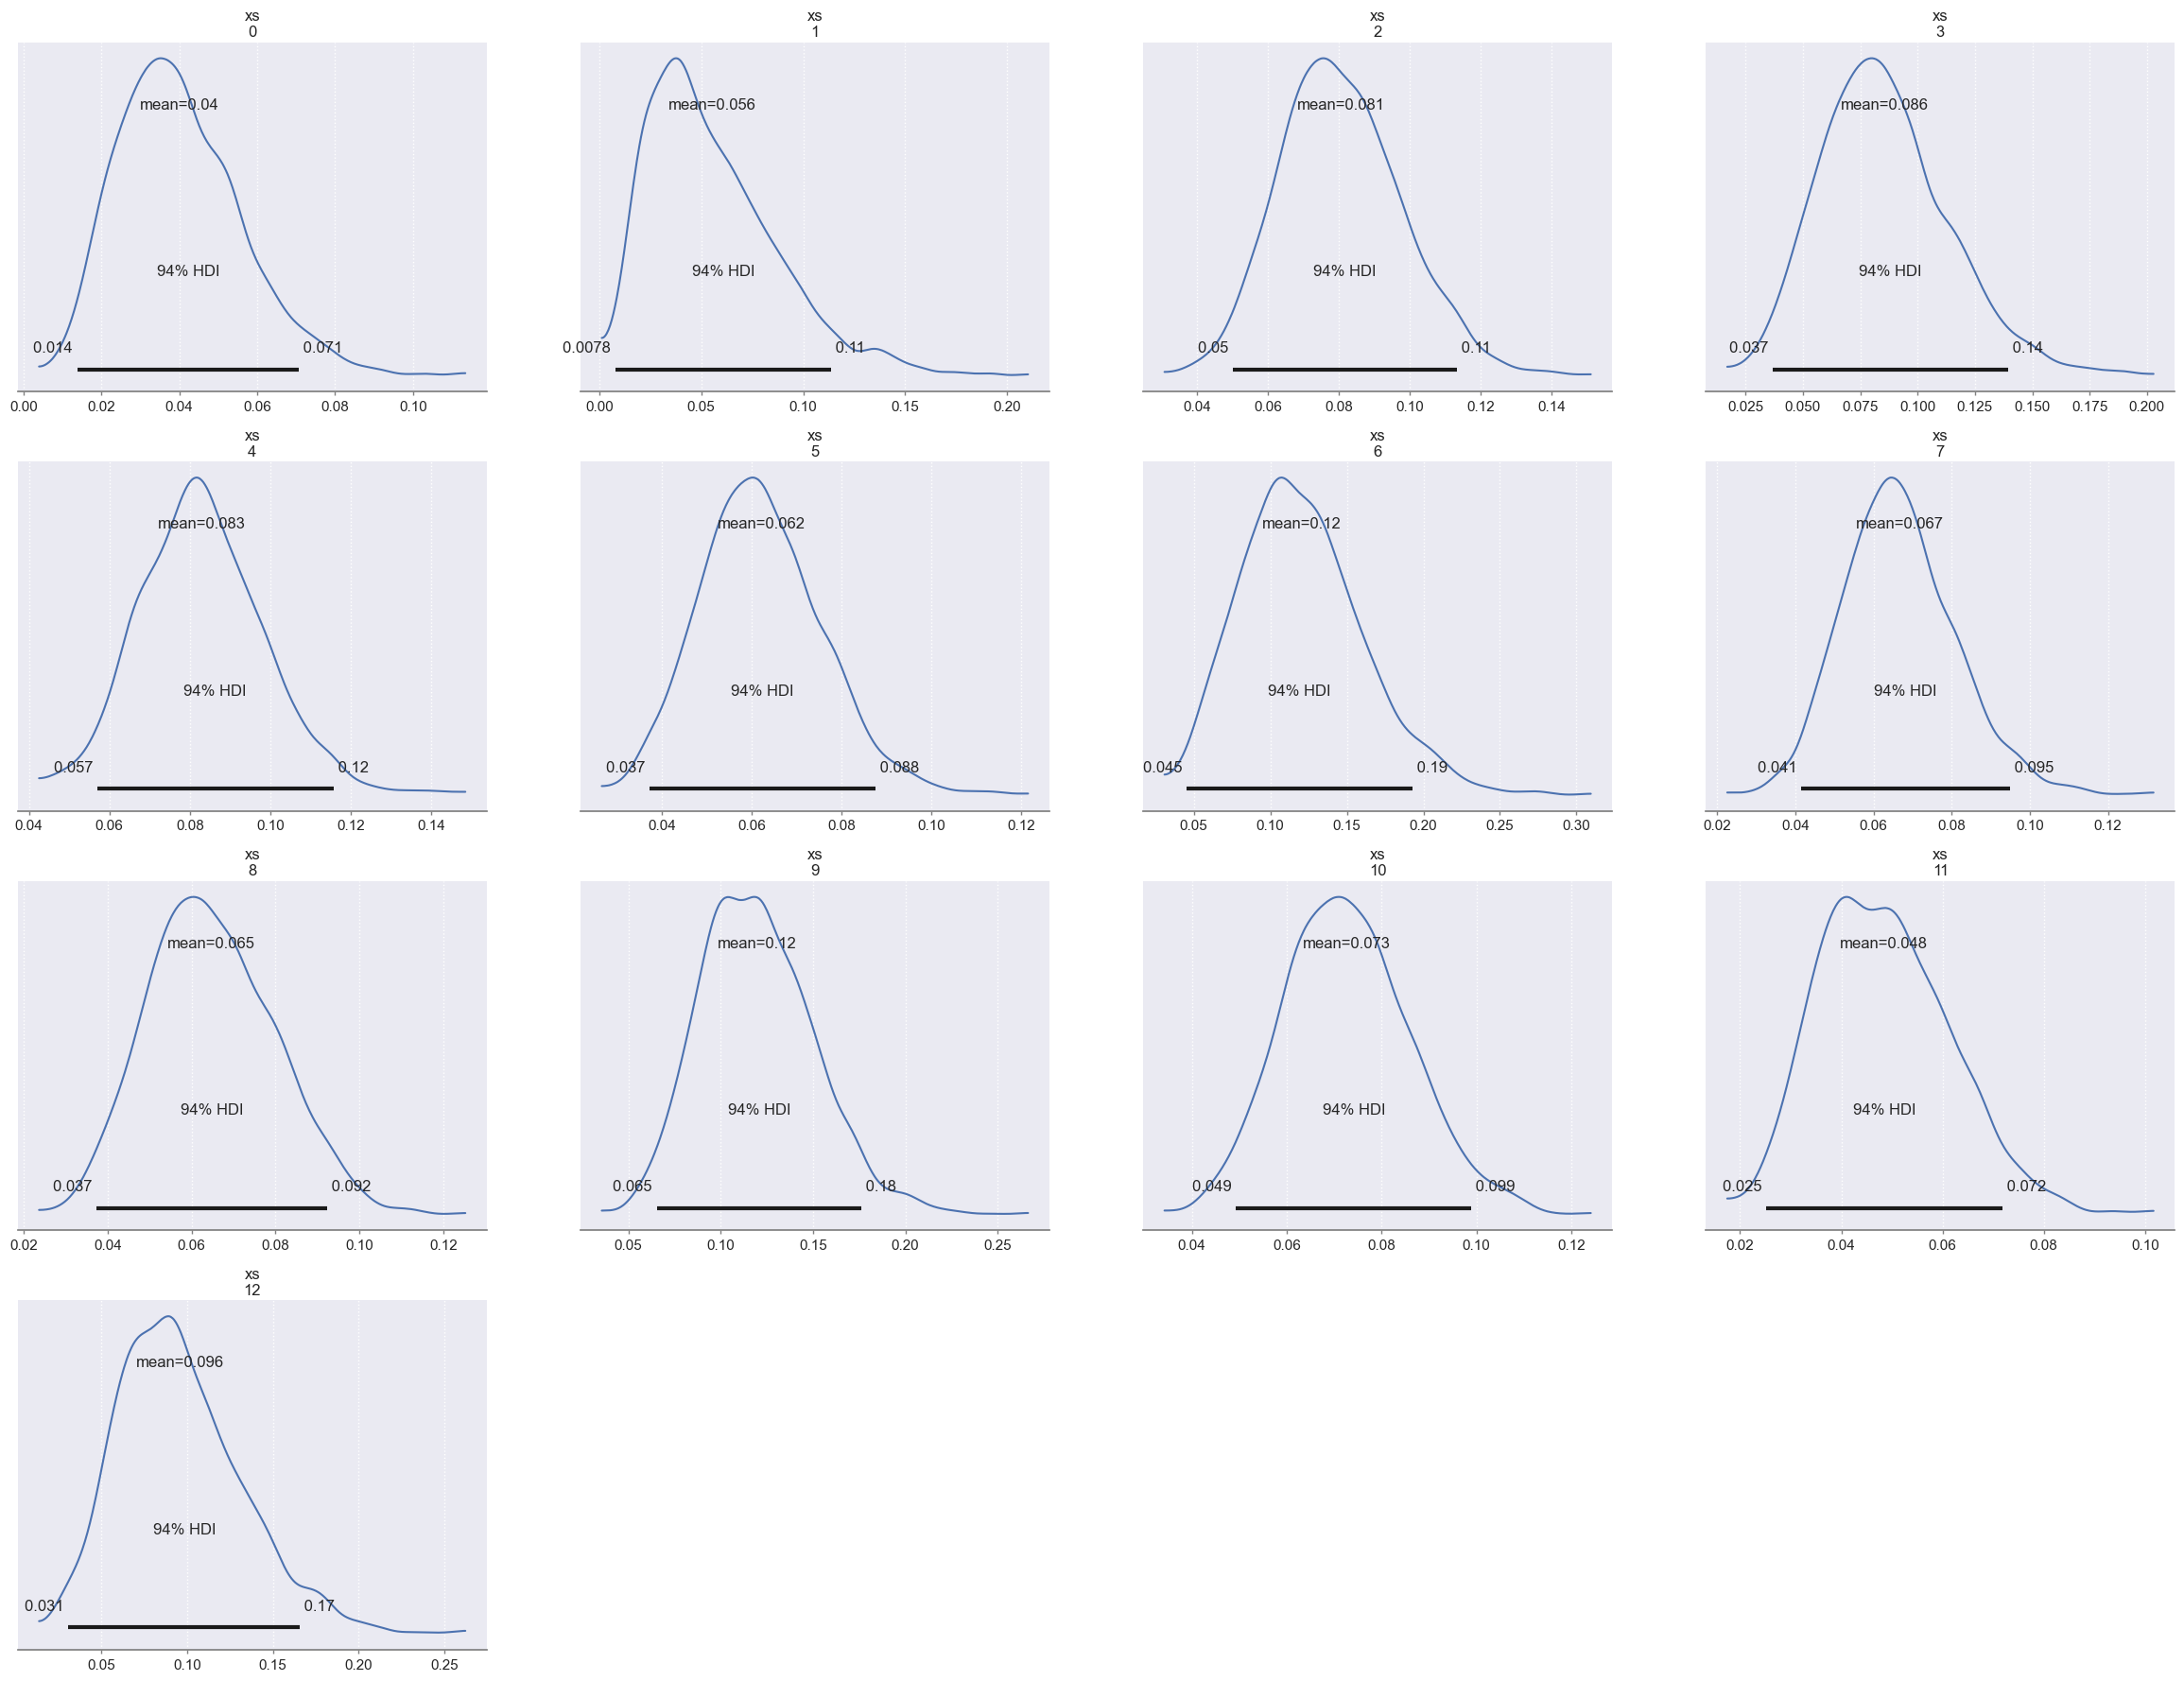

In [15]:
with model:
    az.plot_posterior(trace, var_names=["xs"])

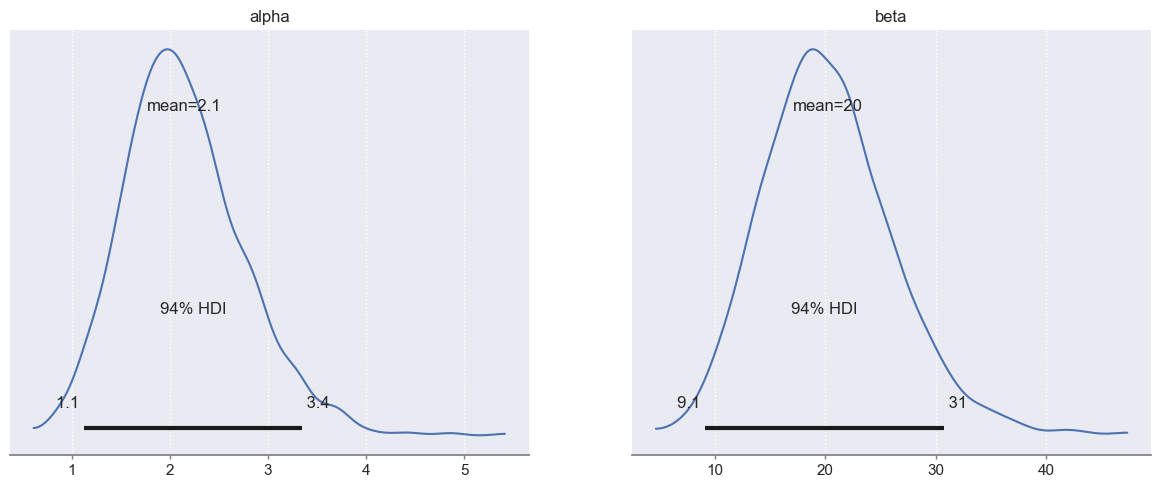

In [16]:

with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta'])

In [23]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

Sampling: [ks]


Output()

In [24]:
posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data

/var/folders/b9/by4645sj1qs3zlbv_gjj27_c0000gp/T/ipykernel_11260/1031561115.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


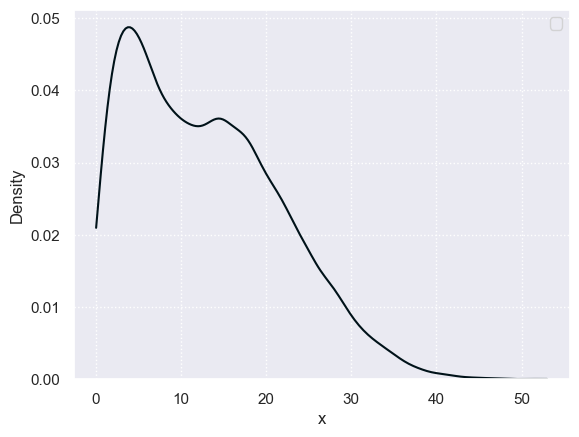

In [25]:
plt.figure()
ax = plt.gca()
ax.set_prop_cycle(linestyle_cycler)
sns.kdeplot(posterior_predictive["posterior_predictive"]["ks"].values.flatten(), cut=0)
plt.xlabel("x")
plt.legend()